In [61]:
import numpy as np
import sys
sys.path.append('..')
from Common.utils import read_data, ButterWorthFilter, numerical_grad_nd
from regression_utils import build_dataset_RR
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import PolynomialFeatures

matplotlib.rc('font', **{'size': 16})
plt.rcParams.update({
  "text.usetex": True
})

In [62]:
def ReLU(x):
    x_c = np.copy(x)
    x_c[x_c<0] = 0
    return x_c

def feature_tri_25(X):
    aug = X
    for k in range(1,26):
        aug = np.concatenate([aug, np.sin(k * np.pi * X)], axis=1)
        aug = np.concatenate([aug, np.cos(k * np.pi * X)], axis=1)
    poly = PolynomialFeatures(1)
    X = poly.fit_transform(aug)
    return X

def feature_tri_6(X):
    aug = X
    for k in range(1,7):
        aug = np.concatenate([aug, np.sin(k * np.pi * X)], axis=1)
        aug = np.concatenate([aug, np.cos(k * np.pi * X)], axis=1)
    poly = PolynomialFeatures(1)
    X = poly.fit_transform(aug)
    return X

In [63]:
dataset = read_data('../data/trajectories/traj16_z.panda.dat')
time = dataset[:,0]
qDot_real = dataset[:,15:15+7]
q_real = dataset[:,1:1+7]
tau_real = dataset[:,29:29+7]
q_ref = dataset[:,8:8+7]
u_cmd = dataset[:, 22:22+7]
G_dat = dataset[:,36:36+7]
C_dat = dataset[:, 43:43+7]
M_dat = dataset[:, 50:50+49]
u_G = u_cmd + G_dat
qD_ref = numerical_grad_nd(q_ref)
qDot_real_filtered, tau_real_filtered = ButterWorthFilter(qDot_real, tau_real, time)
qDDot_inf = numerical_grad_nd(qDot_real_filtered) # numerical derivative to get joints acceleration.

tau_MCG = []
for i in range(len(tau_real)):
    tau_i = M_dat[i,:].reshape(7,7) @ qDDot_inf[i, :].reshape(7,1)
    tau_i += C_dat[i,:].reshape(7,1)
    tau_i += G_dat[i,:].reshape(7,1)
    tau_MCG.append(tau_i)

tau_MCG = np.array(tau_MCG).reshape(len(tau_real), 7)
X = np.concatenate([q_real, qDot_real_filtered],axis=1)
e = X - np.concatenate([q_ref, qD_ref], axis=1)

In [64]:
decoupling_beta = np.loadtxt('Regression_weight/Tri_feature_decoupling.txt')
last3_beta = np.loadtxt('Regression_weight/last_3_joint_RR.txt')
l3_beta = np.loadtxt('Regression_weight/net.4.weight.txt')
l2_beta = np.loadtxt('Regression_weight/net.2.weight.txt')
l1_beta = np.loadtxt('Regression_weight/net.0.weight.txt')
l3_bias = np.loadtxt('Regression_weight/net.4.bias.txt')
l2_bias = np.loadtxt('Regression_weight/net.2.bias.txt')
l1_bias = np.loadtxt('Regression_weight/net.0.bias.txt')

la3_l3_beta = np.loadtxt('Regression_weight/last3_net.4.weight.txt')
la3_l2_beta = np.loadtxt('Regression_weight/last3_net.2.weight.txt')
la3_l1_beta = np.loadtxt('Regression_weight/last3_net.0.weight.txt')
la3_l3_bias = np.loadtxt('Regression_weight/last3_net.4.bias.txt')
la3_l2_bias = np.loadtxt('Regression_weight/last3_net.2.bias.txt')
la3_l1_bias = np.loadtxt('Regression_weight/last3_net.0.bias.txt')

In [65]:
Xe = np.concatenate([e, X], axis=1)

In [66]:
l1_out = ReLU(l1_beta @ X.T + l1_bias[:, np.newaxis])
l2_out = ReLU(l2_beta @ l1_out + l2_bias[:, np.newaxis])
l3_out = l3_beta @ l2_out + l3_bias[:, np.newaxis]

In [67]:
la3_l1_out = ReLU(la3_l1_beta @ e.T + la3_l1_bias[:, np.newaxis])
la3_l2_out = ReLU(la3_l2_beta @ la3_l1_out + la3_l2_bias[:, np.newaxis])
la3_l3_out = la3_l3_beta @ la3_l2_out + la3_l3_bias[:, np.newaxis]

In [68]:
# last_3_res = feature_tri_6(X) @ last3_beta
res_comp = np.concatenate([l3_out.T, la3_l3_out.T], axis=1)

In [69]:
fric_pred = []
for i in range(7):
    x = np.concatenate([X[:, i:i+1], X[:, 7+i:i+8]], axis=1)
    fric_pred_i = feature_tri_25(x)@decoupling_beta[:, i:i+1]
    fric_pred.append(fric_pred_i)
    
fric_pred = np.concatenate(fric_pred, axis=1)

In [70]:
print('Residual compensation: %.3f' % (((tau_real-tau_MCG-res_comp)**2).sum() / len(u_G)))

Residual compensation: 1.548


In [71]:
print('No compensation: %.3f' % (((u_G-tau_MCG)**2).sum() / len(u_G)))
print('Add fric: %.3f' % (((u_G-tau_MCG-fric_pred)**2).sum() / len(u_G)))
print('Add fric + res: %.3f' % (((u_G-tau_MCG-fric_pred-res_comp)**2).sum() / len(u_G)))

No compensation: 8.923
Add fric: 1.592
Add fric + res: 1.008


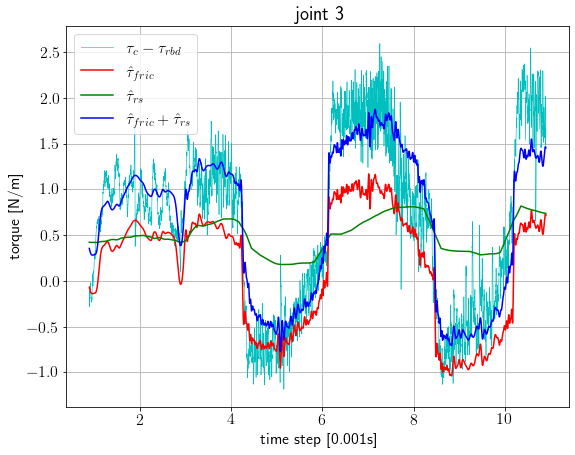

In [72]:
plt.figure(figsize=[9,7])
# for channel in range(7):
#     plt.subplot(4,2,channel+1,xlabel="0.001s", ylabel="Torque of {}. joint[n/m]".format(channel+1))
channel = 3
plt.grid()
plt.plot(time[:10000], (u_G-tau_MCG)[:10000,channel],'-c', label=r"$\tau_{c} - \tau_{rbd}$", linewidth=0.6)
plt.plot(time[:10000], fric_pred[:10000, channel], '-r', label=r"$\hat{\tau}_{fric}$")
plt.plot(time[:10000], res_comp[:10000, channel], '-g', label=r"$\hat{\tau}_{rs}$")
plt.plot(time[:10000], (res_comp+fric_pred)[:10000, channel], '-b', label=r"$\hat{\tau}_{fric} + \hat{\tau}_{rs}$")
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
plt.legend(fancybox=True)
plt.xlabel('time step [0.001s]')
plt.ylabel('torque [N/m]')
plt.title('joint 3')
plt.savefig('/home/jiayun/Desktop/residual.jpg', dpi=150)
plt.show()

In [73]:
fric_pred.shape
res_comp.shape
np.save('../Common/friction_compensation.npy', fric_pred)
np.save('../Common/residual_compensation.npy', res_comp)